In [1]:
import time
import random
from math import *
import operator
import pandas as pd
import numpy as np

# import plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
#from pandas.plotting import scatter_matrix
%matplotlib inline
#plt.style.use(['fivethirtyeight'])
#mpl.rcParams['lines.linewidth'] = 2
import seaborn as sns
sns.set(style='white', font_scale=.8)
sns.set_context('talk')

# import the ML algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from statsmodels.tools.eval_measures import rmse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree

# pre-processing
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA


# import libraries for model validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut 

# import libraries for metrics and reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

##### Reading the dataset

In [2]:
# Importing the dataset 
location = r"C:\Users\madhu\Kaggle_kernels\datasets\novel-corona-virus-2019-dataset\covid_19_data.csv"
virus = pd.read_csv(location, parse_dates=['ObservationDate', 'Last Update'])
virus.drop('SNo', axis=1, inplace=True)
virus.head()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


#### Feature information

In [3]:
virus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2379 entries, 0 to 2378
Data columns (total 7 columns):
ObservationDate    2379 non-null datetime64[ns]
Province/State     1718 non-null object
Country/Region     2379 non-null object
Last Update        2379 non-null datetime64[ns]
Confirmed          2379 non-null float64
Deaths             2379 non-null float64
Recovered          2379 non-null float64
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 130.2+ KB


In [4]:
'''# Looking at the shape and datatype of the features
print(virus.dtypes)
categorical = [var for var in virus.columns if virus[var].dtypes=='object']
numerical = [var for var in virus.columns if virus[var].dtypes!='object']
cat_len = len(categorical)
num_len = len(numerical)
print("There are a total of {} entries and {} features with {} categorical and {} numerical columns"
      .format(virus.shape[0], virus.shape[1], cat_len, num_len))'''

'# Looking at the shape and datatype of the features\nprint(virus.dtypes)\ncategorical = [var for var in virus.columns if virus[var].dtypes==\'object\']\nnumerical = [var for var in virus.columns if virus[var].dtypes!=\'object\']\ncat_len = len(categorical)\nnum_len = len(numerical)\nprint("There are a total of {} entries and {} features with {} categorical and {} numerical columns"\n      .format(virus.shape[0], virus.shape[1], cat_len, num_len))'

##### List of affected countries

In [5]:
countries = virus['Country/Region'].unique().tolist()
print(countries,"\n")
print("The total number of countries affected are {} ".format(len(countries)))

['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan', 'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia', 'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France', 'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast', 'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy', 'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt', 'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan', 'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia', 'Switzerland'] 

The total number of countries affected are 46 


Creating a dataframe with total no of confirmed cases for every country


Since this data is cumulative we must go for max() instead of sum()

##### Global statistics

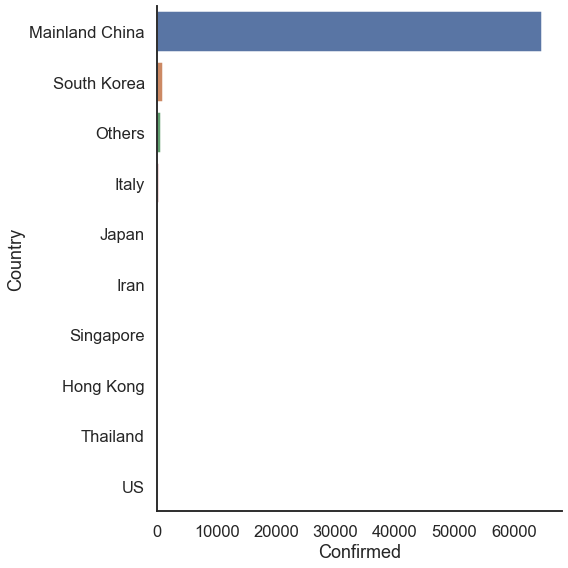

In [6]:
worldwide_cases_stats = pd.DataFrame(virus.groupby(['Country/Region']).max()
                                  ['Confirmed']).rename_axis('Country').reset_index().sort_values('Confirmed', ascending=False)
sns.catplot(x='Confirmed', y='Country', data=worldwide_cases_stats.head(10), kind='bar', ci='sd', height=8)

This graph doesnt reveal much information about other part of the world as china leads way ahead in the affected cases


To get a global picture of affected let keep China aside for a while and revisit the statistics

##### Global statistics excluding Mainland China

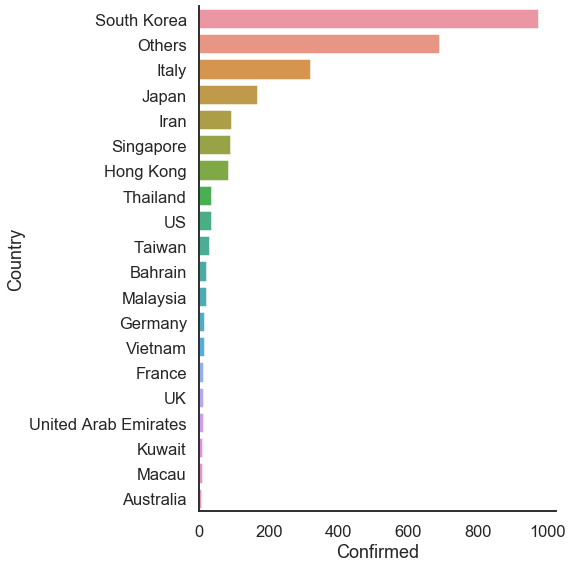

In [8]:
outside_china_stats = worldwide_cases_stats[worldwide_cases_stats.Country!='Mainland China'].sort_values('Confirmed', ascending=False)
sns.catplot(x='Confirmed', y='Country', data=outside_china_stats.head(20), kind='bar', ci='sd', height=8)

South Korea registers more number of affected statistics after China

It is misterious that Italy comes second after South Korea as no other countries from western Europe are listed in top

The same way unnamed category 'Others' also need interrogation

###### Mainland China statistics

In [9]:
china_stats = virus[virus['Country/Region']=='Mainland China']
province_stats = pd.DataFrame(china_stats.groupby(['Province/State']).max()
                              [['Confirmed','Recovered','Deaths']]).reset_index().rename_axis()

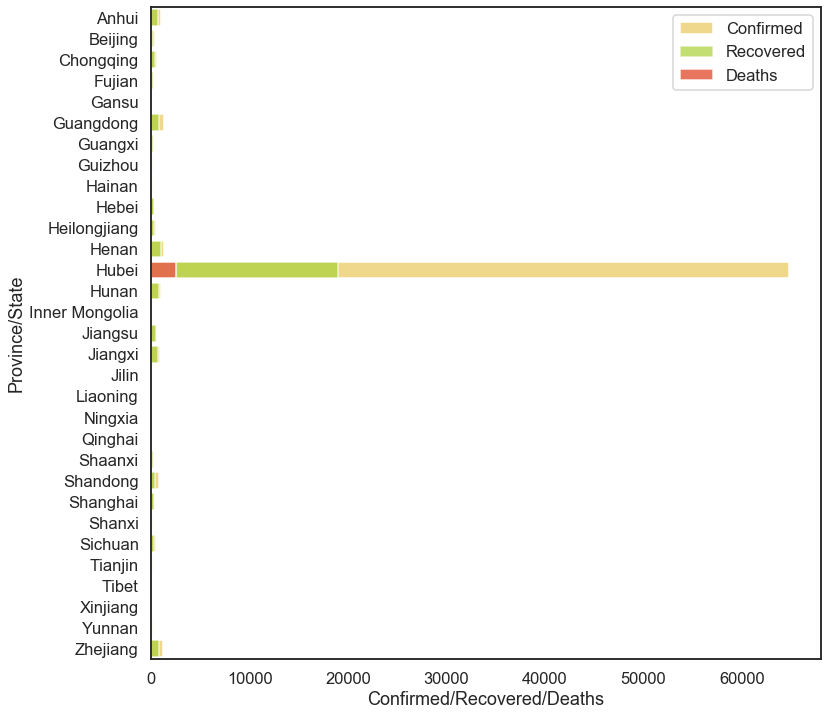

In [10]:
#plt.figure(figsize=(12,12))
fig, ax = plt.subplots(figsize=(12,12))
sns.barplot(y='Province/State', x='Confirmed', data=province_stats, color='#FFE17B', ax=ax, label='Confirmed')
sns.barplot(y='Province/State', x='Recovered', data=province_stats, color='#B7EC1E', alpha=0.7, ax=ax, label='Recovered')
sns.barplot(y='Province/State', x='Deaths', data=province_stats, color='#FF5733', alpha=0.9, ax=ax, label='Deaths')
plt.xlabel('Confirmed/Recovered/Deaths')
plt.legend()

Since Hubei has reported the highest number of cases the graph actually is not showing much of the info about other provinces. So lets keep Hubei aside for a while and lets see other provinces

##### Looking at the statistics of Mainland China excluding Hubei

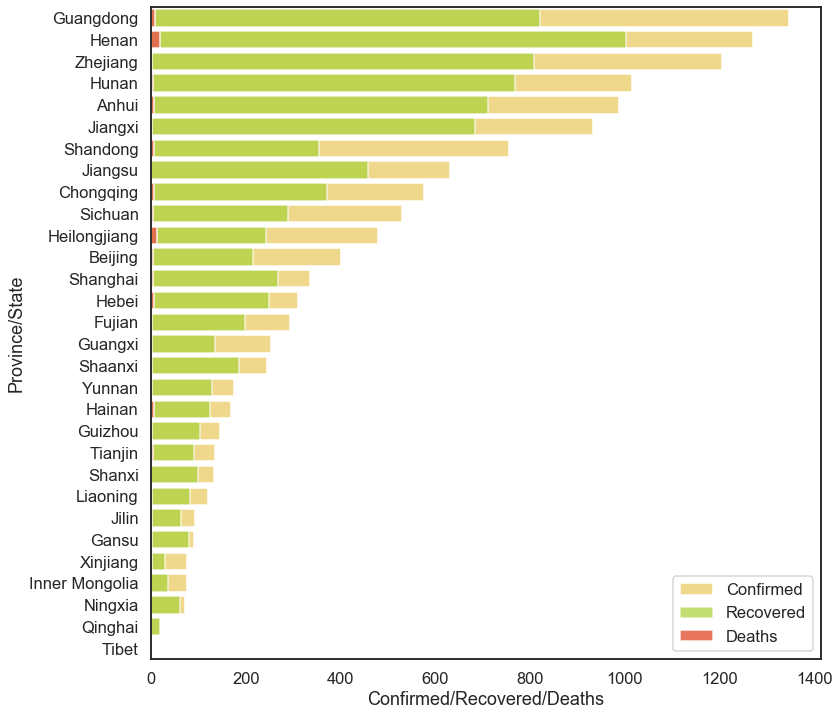

In [11]:
province_stats_exclude_hubei = province_stats[province_stats['Province/State']!='Hubei'].sort_values(['Confirmed'],
                                                                                                     ascending=False)
fig, ax = plt.subplots(figsize=(12,12))
sns.barplot(y='Province/State', x='Confirmed', data=province_stats_exclude_hubei, color='#FFE17B', ax=ax, label='Confirmed')
sns.barplot(y='Province/State', x='Recovered', data=province_stats_exclude_hubei, color='#B7EC1E',alpha=0.7, ax=ax, label='Recovered')
sns.barplot(y='Province/State', x='Deaths', data=province_stats_exclude_hubei, color='#FF5733',alpha=0.9, ax=ax, label='Deaths')
#ax.set_xlim(0,1000)
plt.xlabel('Confirmed/Recovered/Deaths')
plt.legend()

##### Hubei - Standalone analysis

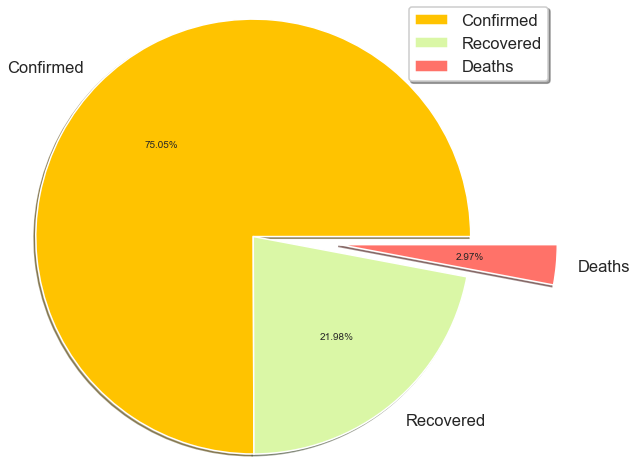

In [12]:
province_stats_hubei = province_stats[province_stats['Province/State']=='Hubei'].sort_values('Confirmed', ascending=False)
fig, ax = plt.subplots()
ax.pie(province_stats_hubei.groupby(['Province/State']).max(), labels=['Confirmed','Recovered','Deaths'], 
       autopct='%.2f%%', explode=(0,0,1), shadow=True, radius=2.5, colors=['#FFC300','#DAF7A6','#FF7269'])
#plt.axis('equal')
plt.legend(loc='lower left', borderaxespad=16, fancybox=True, shadow=True)
plt.show()

As per the Latest Census the population of Hubei is 5.85 crores. The total affected count is 86320 which is around 0.14% of total population. among this 2.97% surrendered to death and 21.98% tested negative after treatment.